In [1]:
%matplotlib inline
from pylab import *
import cv2
import rasterio

rcParams['figure.figsize'] = 10, 10

from dataset import load_image

import torch
from torch import nn
from torch.nn import functional as F
import torch
from torchvision import models
import torchvision
from torchvision.transforms import ToTensor, Normalize, Compose
from utils import variable
from generate_masks import get_model
from unet_models import unet11


/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


# DEMO ALTERED. THESE CELLS GENERATE SOME DATA

In [2]:
# import the helper functions
from test_unet_helpers import *

import glob
import os,sys
from matplotlib import pyplot as plt
import numpy as np
from scipy import misc
import fiona
from shapely.geometry import shape
import shapely
from rasterio.mask import mask
from pyproj import Proj, transform

/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [3]:
# specify scene id for DG data
dg_scene_id = '1030010057062200'

# specify image for 2.0 meter analysis
gt_image_2 = '../rasters/union_impervious_raster_2_0_0_wgs84.tif' # desktop

# specify images for 0.5 meter analysis
gt_image_05 = '../rasters/union_impervious_raster_0_5.tif' # desktop

# specify the shapefile
shpfile = '../union/union.shp' # desktop
rows = []
with fiona.open(shpfile) as shp:
    crs = shp.crs
    shp_bounds = shp.bounds

In [4]:
from gbdxtools import Interface, CatalogImage

# connect to gbdx
gbdx = Interface()

# get the dask array for the 8 band MS image
img_2m = CatalogImage(dg_scene_id, band_type='MS', bbox=shp_bounds, acomp=True)
rows, cols = img_2m.shape[1:]

# get the dask array for the Pansharpened, 4 band image
image_05m = CatalogImage(dg_scene_id, bbox=shp_bounds, acomp=True, pansharpen=True)
rowsP, colsP = image_05m.shape[1:]
pan_factorR = np.floor(rowsP/rows)
pan_factorC = np.floor(colsP/cols)

In [5]:
torch.cuda.device_count()

4

In [6]:
# generate the sample points
# we have some funny stuff from ArcGIS converting the polygons to a raster... so... 
# generate the points within the bounds of the shapefile / DG image array

import random

random.seed(10)

num = 10000
side = 64
coords = []
coords_pan = []
im_patches = []
im_patches_pan = []

with rasterio.open(gt_image_2, 'r') as src:
    
    for i in range(num):
        ran_row, ran_col = random.randrange(0,rows), random.randrange(0,cols)
        #print('generating sample {} of {}'.format(i+1, num))

        try:
            r_start = ran_row - side/2
            r_end = ran_row + side/2
            c_start = ran_col - side/2
            c_end = ran_col + side/2
            #im_data = img_2m[:, r_start:r_end, c_start:c_end]

            pr_start = ran_row*pan_factorR - side/2
            pr_end = ran_row*pan_factorR + side/2
            pc_start = ran_col*pan_factorC - side/2
            pc_end = ran_col*pan_factorC + side/2
            #im_data_pan = image_05m[:, pr_start:pr_end, pc_start:pc_end]

            # append regardless and check later.

            #############################################################################################################
            ### SHOULD CHECK THE INFORMATION THRESHOLDS BELOW, BUT HERE, TO RESELECT ROWS AND COLUMNS UNTIL IT IS MET ###
            #############################################################################################################

            s_pt = calcXYfromRC(img_2m.affine, (ran_row, ran_col))
            pt_flag = checkWindow(src, s_pt)
            ct = 0
            while pt_flag:
                ran_row, ran_col = random.randrange(0,rows), random.randrange(0,cols)
                s_pt = calcXYfromRC(img_2m.affine, (ran_row, ran_col))
                pt_flag = checkWindow(src, s_pt)
                
                ct+=1
                # exit loop after 1000 tries
                if ct > 1000:
                    break
            if ct > 1000:
                print('1000 tries, moving on')
                continue
                
                
            coords.append((ran_row, ran_col))
            coords_pan.append(( int(ran_row*pan_factorR), int(ran_col*pan_factorC)))

        except Exception as e:
            print(e)

    coords_arr = np.array(coords)  

/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [7]:
lonlat_MS = [calcXYfromRC(img_2m.affine, pair) for pair in coords]
lonlat_PAN = [calcXYfromRC(image_05m.affine, pair) for pair in coords_pan]

In [8]:
import pyproj
       
def assignRC2(rio_obj, samp_pt, window_size=64, inproj='epsg:4326', outproj='epsg:32613'):
    # project the point to source crs
    outProj = Proj(init=outproj)
    inProj = Proj(init=inproj)
    x1,y1 = samp_pt        
    x2,y2 = pyproj.transform(inProj, outProj ,x1,y1)
    x3,y3 = pyproj.transform(outProj, inProj, x2,y2)
    
    # get the row column
    temp = rio_obj.index(x2,y2)
    r,c = [int(c) for c in temp]
    
    return ((x3,y3), samp_pt, r,c)

def assignRC3(rio_obj, samp_pt, window_size=64, inproj='epsg:4326', outproj='epsg:32613'):
    # project the point to source crs
    #outProj = Proj(init=outproj)
    #inProj = Proj(init=inproj)
    x1,y1 = samp_pt        
    #x2,y2 = pyproj.transform(inProj, outProj ,x1,y1)
    #x3,y3 = pyproj.transform(outProj, inProj, x2,y2)
    
    # get the row column
    temp = rio_obj.index(x1,y1)
    r,c = [int(c) for c in temp]
    
    return ((x1,y1), samp_pt, r,c)

# use the lonlats_* lists to sample the ground truth image. return the histogram if the window is on the border,
# which should be evident if the window extends across
with rasterio.open(gt_image_2, 'r') as src:
    #print(src.crs)

    # cull the lon/lat points by checking if they include nodata pixels
    gt_pts_MS = [assignRC3(src, samp_pt) for samp_pt in lonlat_MS]

# do the same for the 0.5 meter ground truth raster
with rasterio.open(gt_image_05, 'r') as src:

    # cull the lon/lat points by checking if they include nodata pixels
    gt_pts_PAN = [assignRC(src, samp_pt) for samp_pt in lonlat_MS]




In [9]:
# image transform for DG imagery

img_transform = Compose([
    Normalize(mean=[1630.7322, 1574.9552, 1549.1031], std=[837.0847 , 766.4114 , 604.51605])
])

## Train the initial model with a subset of the sample points.. need to edit the source code to use the input data classes instead of data loaders.
### to use the dataloader, may need to create some attributes on the class such as self.__len__

In [10]:
val_test_percentage = 0.2
train_ind = int(num - num * val_test_percentage)
val_ind = int((num - train_ind)*0.5)
val_ind = train_ind + val_ind
train_ind, val_ind


(8000, 9000)

In [11]:
bsize = 100

## establish the data loaders
from torch.utils.data import DataLoader

# ground truth
gt_transform = Compose([
    ToTensor()
    ])
# gt_dataset_train = gtDatasetSampler2(gt_image_2, coords[:train_ind], transform=gt_transform) 
gt_dataset_train = gtDatasetSampler2(gt_image_2, coords[:1000], transform=gt_transform) # debug 
gt_dataset_val = gtDatasetSampler2(gt_image_2, coords[train_ind:val_ind], transform=gt_transform)
gt_dataset_test = gtDatasetSampler2(gt_image_2, coords[val_ind:], transform=gt_transform)

gt_dl_train = DataLoader(gt_dataset_train, batch_size=bsize, shuffle=False)
gt_dl_val = DataLoader(gt_dataset_val, batch_size=bsize, shuffle=False)


#DG
# dg_dataset_train = DigitalGlobeSamplerTensor(img_2m, coords[:train_ind], transform=img_transform) # will return RGB by default
dg_dataset_train = DigitalGlobeSamplerTensor(img_2m, coords[:1000], transform=img_transform) # debug
dg_dataset_val = DigitalGlobeSamplerTensor(img_2m, coords[train_ind:val_ind], transform=img_transform)
dg_dataset_test = DigitalGlobeSamplerTensor(img_2m, coords[val_ind:], transform=img_transform)

dg_dl_train = DataLoader(dg_dataset_train, batch_size=bsize, shuffle=False)
dg_dl_val = DataLoader(dg_dataset_val, batch_size=bsize, shuffle=False)

In [12]:
class objectview(object):
    def __init__(self, d):
        self.__dict__ = d
        
args = {}
args['lr'] = 0.0001
args['n_epochs'] = 4
args['batch_size'] = bsize
args['root'] = 'runs/debug'
args['fold']=0
args['jaccard_weight'] = 1

# convert dict keys to objects and specify lr
args = objectview(args)
lr = args.lr

In [13]:
from datetime import datetime

def write_event(log, step: int, **data):
    data['step'] = step
    data['dt'] = datetime.now().isoformat()
    log.write(json.dumps(data, sort_keys=True))
    log.write('\n')
    log.flush()
    
save = lambda ep: torch.save({
        'model': model.state_dict(),
        'epoch': ep,
        'step': step,
    }, str(model_path))



In [14]:
import utils as pyt_utils
from torch.optim import Adam
import torch.backends.cudnn as cudnn
from pathlib import Path
from validation import validation_binary
from loss import LossBinary
import json

# need to change this to DICE loss!
#loss = LossBinary(jaccard_weight=args.jaccard_weight)
#criterion = nn.CrossEntropyLoss()


cudnn.benchmark = True

root = Path(args.root)
root.mkdir(exist_ok=True, parents=True)
root.joinpath('params.json').write_text(
    json.dumps(vars(args), indent=True, sort_keys=True))

valid = validation_binary

num_classes=1

In [ ]:
import time
from sklearn.metrics import roc_auc_score, log_loss, roc_auc_score, roc_curve, auc
# from sklearn.cross_validation import StratifiedKFold, ShuffleSplit, cross_val_score, train_test_split

### call outside training method, in loop

# iterate over some batch sizes
times = []
# batch_sizes = [50, 100, 200,300,400,500,600,700,800,900,1000]
bsize = 32 # smaller batch sizes as per https://stats.stackexchange.com/questions/164876/tradeoff-batch-size-vs-number-of-iterations-to-train-a-neural-network
model = unet11(pretrained=False)

# set some parameters
lr = 0.0001
optimizer = Adam(model.parameters(), lr=lr)
criterion = LossBinary(jaccard_weight=args.jaccard_weight)
# criterion = nn.BCELoss()

# make model parallel and on GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # get device for gpu or cpu
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model)
    model.to(device)

optimizer = Adam(model.parameters(), lr=lr)
criterion = LossBinary(jaccard_weight=args.jaccard_weight)
# criterion = nn.BCELoss()

print('batchsize, ', bsize)
mean_loss = 0.0
running_loss = 0.0
print('training...')

losses=[]
losses_ep = []
#tl = zip(dg_dl_train, gt_dl_train)
step=0


###### specify DataLoaders
## GT
gt_dl_train = DataLoader(gt_dataset_train, batch_size=bsize, shuffle=False)
gt_dl_val = DataLoader(gt_dataset_val, batch_size=bsize, shuffle=False)


## DG
dg_dl_train = DataLoader(dg_dataset_train, batch_size=bsize, shuffle=False)
dg_dl_val = DataLoader(dg_dataset_val, batch_size=bsize, shuffle=False)


# record time for one epoch
t0 = time.time()
for epoch in range(100):
    te = time.time()
    
    epoch_i = epoch+1
    print('on epoch {}'.format(epoch_i))
    tl = zip(dg_dl_train, gt_dl_train) # this can't be defined outside the loop. This suggests it is...cashing out??
    for i, (inputs_, targets_) in enumerate(tl):

        # get the inputs
        #inputs, targets = variable(inputs_).cuda(), variable(targets_).cuda()
        inputs, targets = variable(inputs_), variable(targets_)
        inputs.to(device)
        targets.to(device)

        outputs = model(inputs)

        # zero parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize            
        i_loss = criterion(outputs, targets)                
        i_loss.backward()
        optimizer.step()
        step+=1


        if i%10 == 0: # print/store every 10
            losses.append(i_loss)
            #running_loss += i_loss
            #print('[%d, %5d] loss: %.3f' %(epoch, i + 1, i_loss))
    
    # get some numbers for the ROC curve
    if epoch_i%2 == 0:
        pred_y = outputs.cpu().data.numpy().squeeze().flatten()
        target_y = targets.cpu().data.numpy().flatten()
        tu = (i_loss, roc_auc_score(target_y,pred_y ))
        print ('epoch: {}, LOSS={}, ROC_AUC={} '.format(epoch_i, *tu))  

    losses_ep.append(losses)
    te1 = time.time()
    print('time for epoch {}: {} seconds'.format(epoch_i, te1-te))

t1 = time.time()
print ('total time: ',t1 - t0)
times.append(t1-t0)

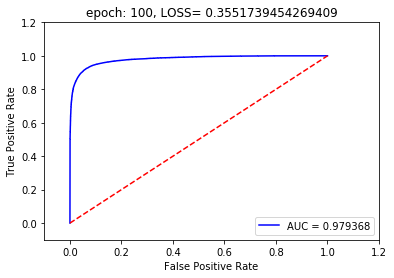

In [16]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(target_y,pred_y)
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.title('epoch: {}, LOSS= {}'.format(epoch_i, i_loss))
plt.plot(false_positive_rate, true_positive_rate, 'b', label='AUC = %0.6f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([-0.1, 1.2])
plt.ylim([-0.1, 1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Performance on the Validation set

In [17]:
model.eval()

DataParallel(
  (module): UNet11(
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (encoder): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace)
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU(inplace)
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace)
      (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace)
      (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (12): ReLU(inplace)
      (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1,

Validation batch: 0, LOSS=1.2408539056777954, ROC_AUC=0.8219259133831227 


/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


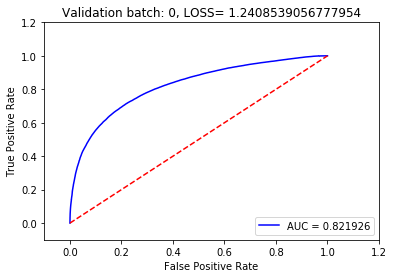

Validation batch: 1, LOSS=1.2769439220428467, ROC_AUC=0.8165360350652303 


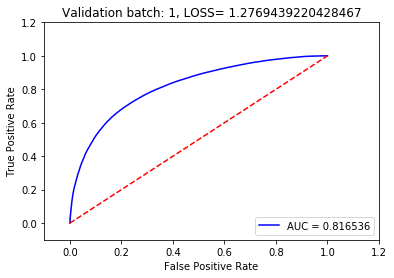

Validation batch: 2, LOSS=1.2071785926818848, ROC_AUC=0.827849467360068 


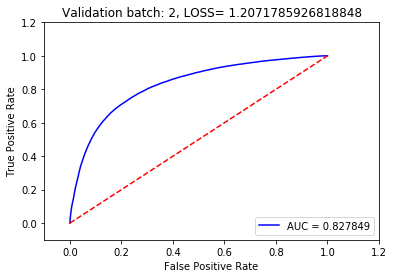

Validation batch: 3, LOSS=1.3333543539047241, ROC_AUC=0.8251064906889822 


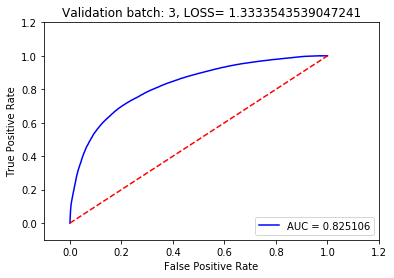

Validation batch: 4, LOSS=1.678966760635376, ROC_AUC=0.76735300911424 


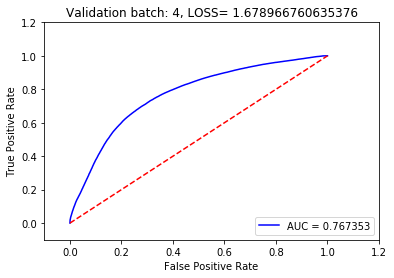

Validation batch: 5, LOSS=1.3722584247589111, ROC_AUC=0.8140537527341316 


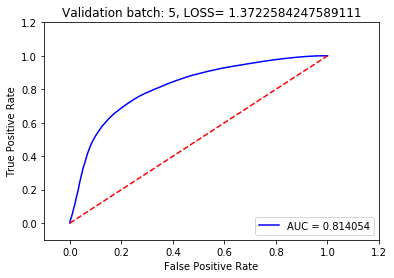

Validation batch: 6, LOSS=1.3093279600143433, ROC_AUC=0.8207532829908355 


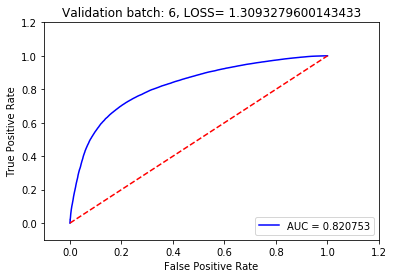

Validation batch: 7, LOSS=1.4419822692871094, ROC_AUC=0.8066238178113427 


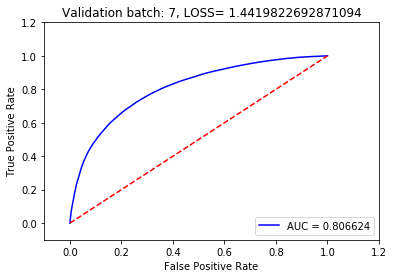

Validation batch: 8, LOSS=1.238095760345459, ROC_AUC=0.8273901317982502 


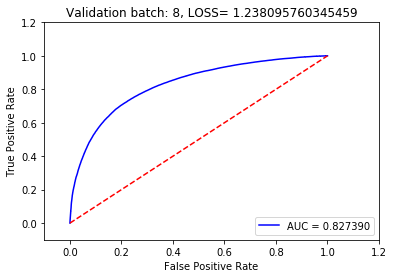

Validation batch: 9, LOSS=1.4996545314788818, ROC_AUC=0.8072926461698142 


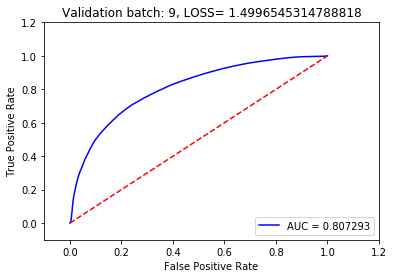

Validation batch: 10, LOSS=1.3421297073364258, ROC_AUC=0.8061352468272394 


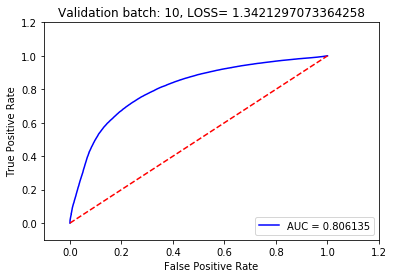

Validation batch: 11, LOSS=1.4300901889801025, ROC_AUC=0.8021127736212894 


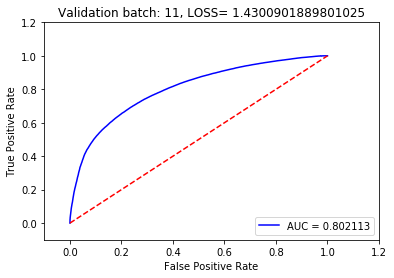

Validation batch: 12, LOSS=1.1897644996643066, ROC_AUC=0.8377448139183108 


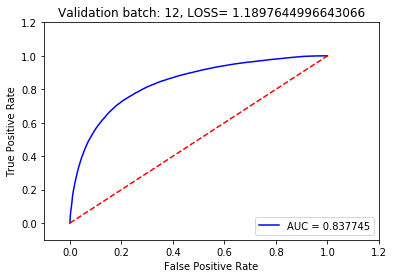

Validation batch: 13, LOSS=1.238115906715393, ROC_AUC=0.8292724737671091 


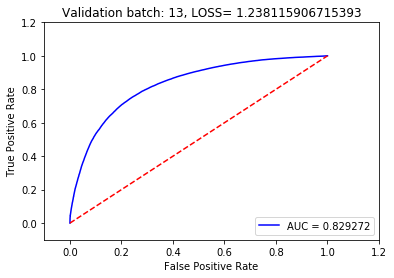

Validation batch: 14, LOSS=1.1935272216796875, ROC_AUC=0.8513127636462188 


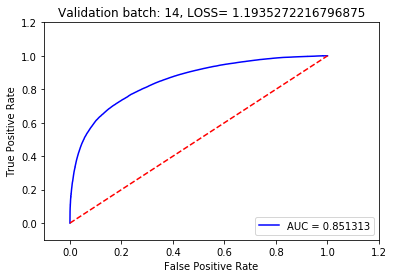

Validation batch: 15, LOSS=1.326936960220337, ROC_AUC=0.8135297110529993 


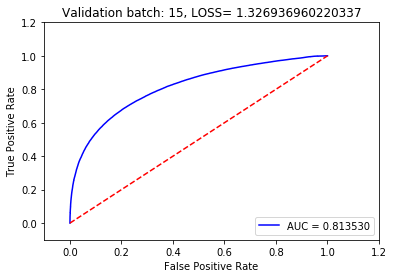

Validation batch: 16, LOSS=1.467782974243164, ROC_AUC=0.7981445761170609 


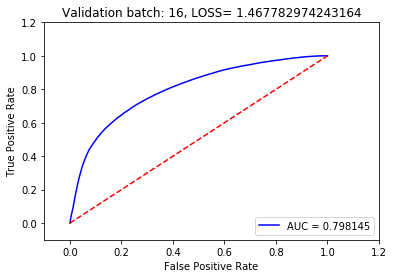

Validation batch: 17, LOSS=1.270350694656372, ROC_AUC=0.8216664222756931 


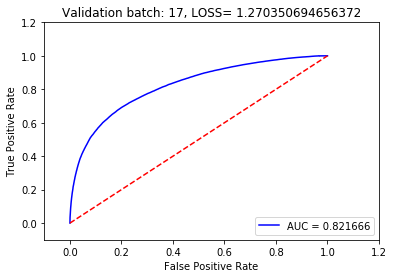

Validation batch: 18, LOSS=1.3472877740859985, ROC_AUC=0.8222252013399114 


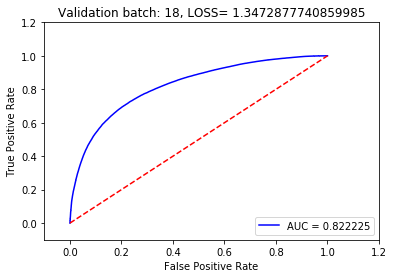

Validation batch: 19, LOSS=1.2774168252944946, ROC_AUC=0.8285521550376198 


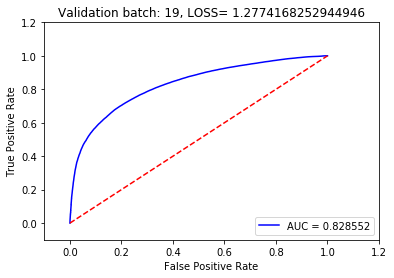

Validation batch: 20, LOSS=1.4151346683502197, ROC_AUC=0.8127270549456234 


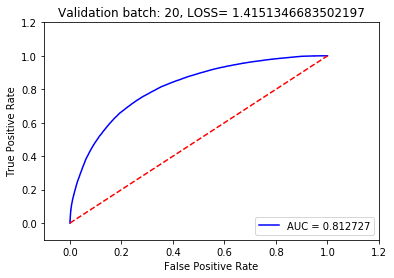

Validation batch: 21, LOSS=1.0656111240386963, ROC_AUC=0.8448186901786453 


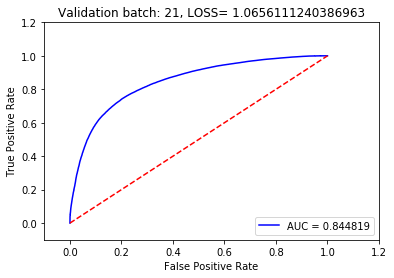

Validation batch: 22, LOSS=1.252109408378601, ROC_AUC=0.8277767077302386 


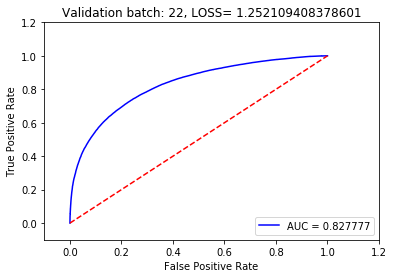

Validation batch: 23, LOSS=1.1394133567810059, ROC_AUC=0.8371646628983622 


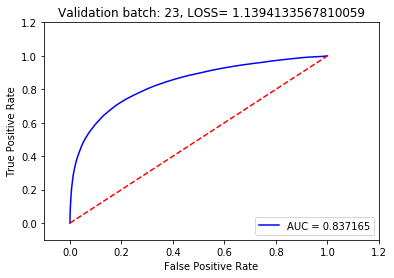

Validation batch: 24, LOSS=1.226168155670166, ROC_AUC=0.8216795145792067 


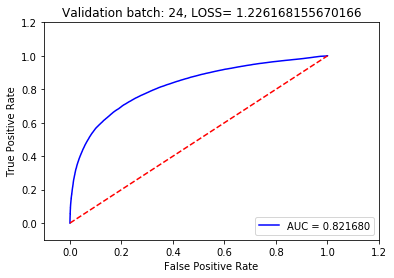

Validation batch: 25, LOSS=1.1924253702163696, ROC_AUC=0.8380208779561966 


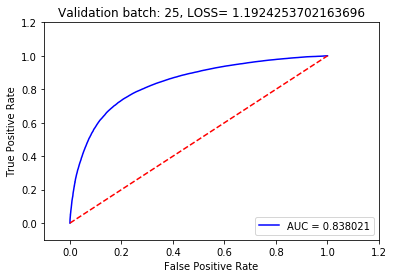

Validation batch: 26, LOSS=1.2751357555389404, ROC_AUC=0.8187193693310884 


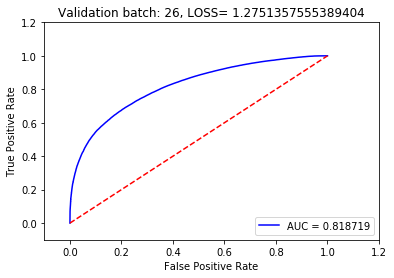

Validation batch: 27, LOSS=1.1229525804519653, ROC_AUC=0.8503869562093123 


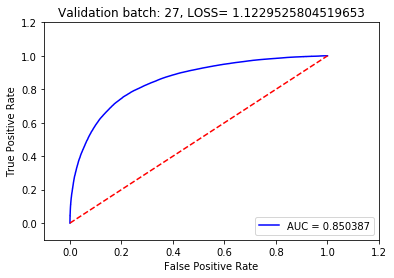

Validation batch: 28, LOSS=1.3344424962997437, ROC_AUC=0.8075108797650398 


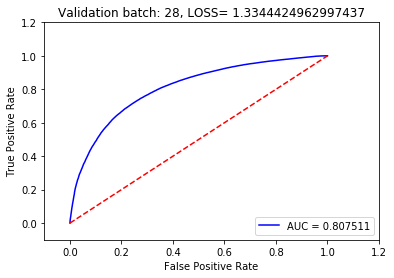

Validation batch: 29, LOSS=1.193796992301941, ROC_AUC=0.8333148889529092 


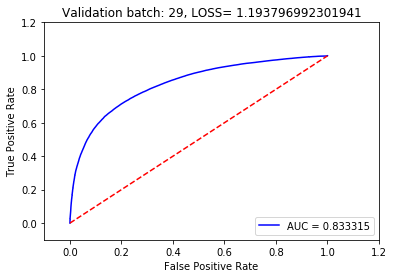

Validation batch: 30, LOSS=1.0881881713867188, ROC_AUC=0.8515209465907263 


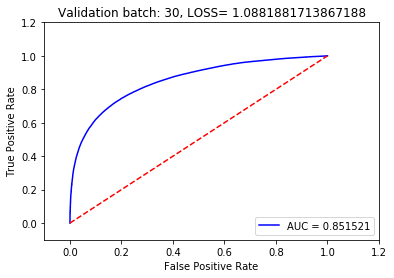

Validation batch: 31, LOSS=1.1617560386657715, ROC_AUC=0.8381105876308883 


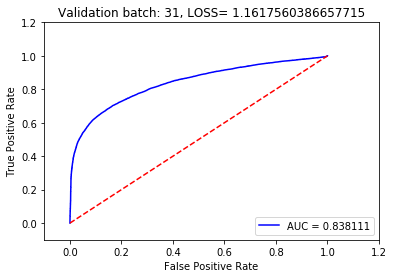

In [18]:
##### Validation data
## ground truth
gt_dl_val = DataLoader(gt_dataset_val, batch_size=bsize, shuffle=False)


## DG
dg_dl_val = DataLoader(dg_dataset_val, batch_size=bsize, shuffle=False)


# define a zipped object for iterating
zl = zip(dg_dl_val, gt_dl_val)

# some lists for plotting all batch ROC curves
all_fpr = []
all_tpr = []
all_thresh = []
all_roc_auc = []
for i_val, (inputs_, targets_) in enumerate(zl):

        # get the inputs
        #inputs, targets = variable(inputs_).cuda(), variable(targets_).cuda()
        inputs, targets = variable(inputs_), variable(targets_)
        inputs.to(device)
        targets.to(device)

        # evaluate
        outputs = model(inputs)
        
        # record loss
        v_loss = criterion(outputs, targets)
        
        # convert to numpy and get ROC params
        pred_y_val = outputs.cpu().data.numpy().squeeze().flatten()
        #pred_y_val[pred_y_val > 0] = 1.
        #pred_y_val[pred_y_val <=0] = 0.
        target_y_val = targets.cpu().data.numpy().flatten()
        tu = (v_loss, roc_auc_score(target_y_val,pred_y_val ))
        print ('Validation batch: {}, LOSS={}, ROC_AUC={} '.format(i_val, *tu))  

        # calculate FPR and TPR, and area-under-curve
        false_positive_rate, true_positive_rate, thresholds = roc_curve(target_y_val,pred_y_val)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        
        # append to lists
        all_fpr.append(false_positive_rate)
        all_tpr.append(true_positive_rate)
        all_thresh.append(thresholds)
        all_roc_auc.append(roc_auc)

        plt.title('Validation batch: {}, LOSS= {}'.format(i_val, v_loss))
        plt.plot(false_positive_rate, true_positive_rate, 'b', label='AUC = %0.6f' % roc_auc)
        plt.legend(loc='lower right')
        plt.plot([0, 1], [0, 1], 'r--')
        plt.xlim([-0.1, 1.2])
        plt.ylim([-0.1, 1.2])
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()





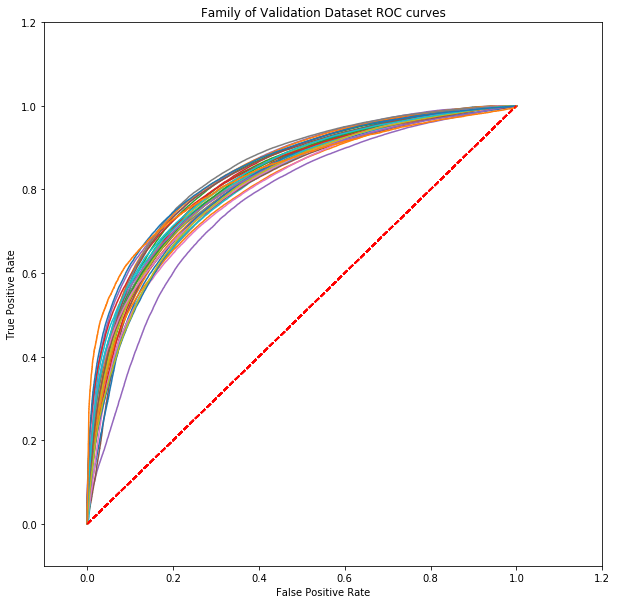

In [19]:
## plot all the validation dataset ROC curves
plt.figure(figsize=(10,10))
plt.title('Family of Validation Dataset ROC curves')
for ind in range(len(all_fpr)):
    
    plt.plot(all_fpr[ind], all_tpr[ind])
    #plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([-0.1, 1.2])
    plt.ylim([-0.1, 1.2])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
#     plt.yscale('log')
#     plt.xscale('log')
    
plt.show()

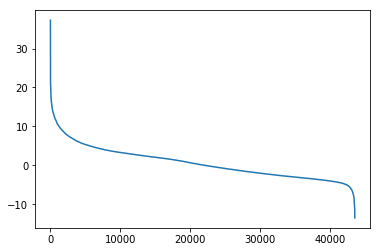

In [20]:
plt.plot(all_thresh[0])

In [21]:
model_path = 'runs/debug/model_e{}_b{}_no_aug_GPUPAR.pt'.format(epoch_i, bsize)
save = lambda ep: torch.save({
        'model': model.state_dict(),
        'epoch': ep,
        'step': step,
    }, str(model_path))

save(epoch)

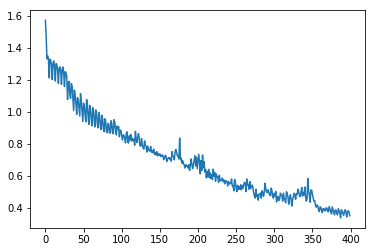

In [22]:
# plot the losses epoch losses from the last 66/100 epochs
# (forgot to record from epoch 0 since I was going in epoch chunks... it is faster with the GPU!!)
plt.plot([l.data.cpu().numpy() for l in losses])

/home/ubuntu/segmentation/IS_segmentation/utils.py:16: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return cuda(Variable(x, volatile=volatile))


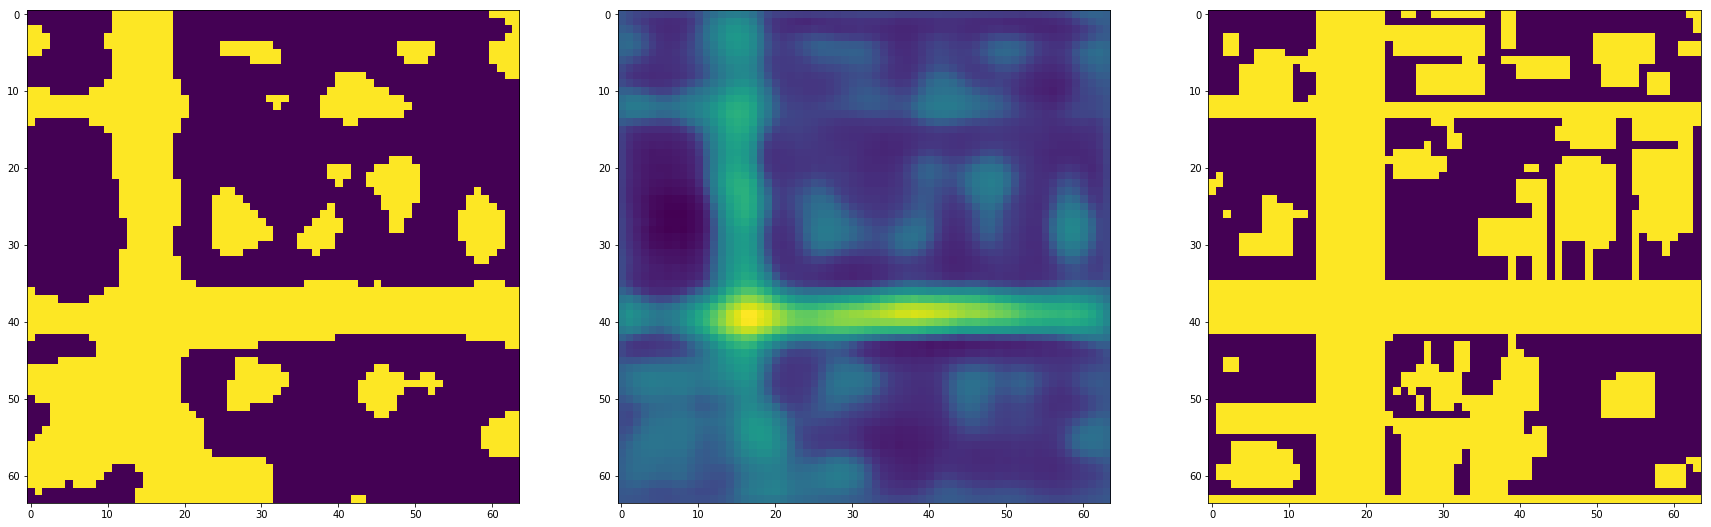

/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/site-packages/ipykernel_launcher.py:25: DeprecationWarning: `bytescale` is deprecated!
`bytescale` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.


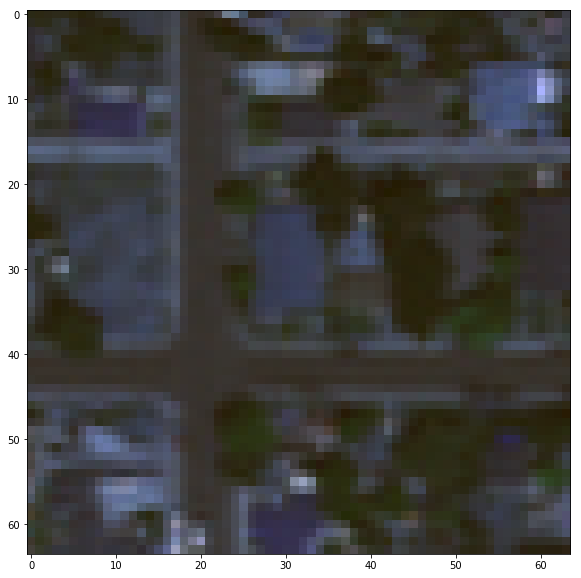

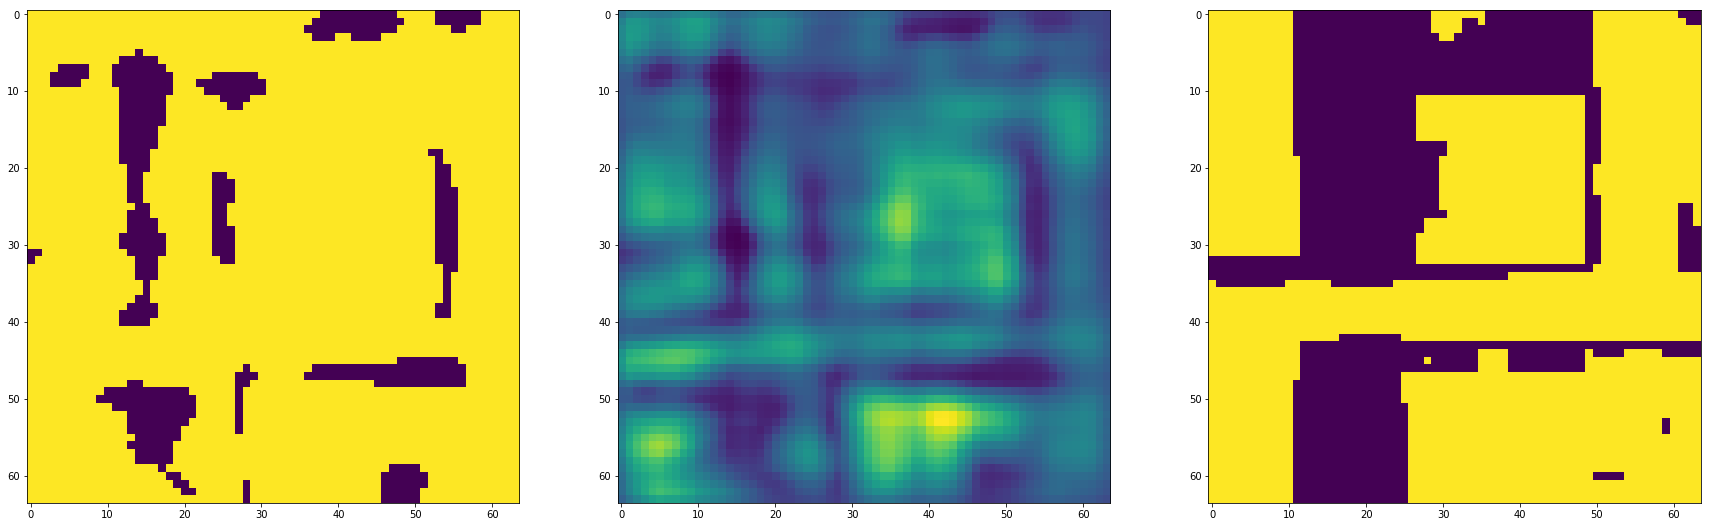

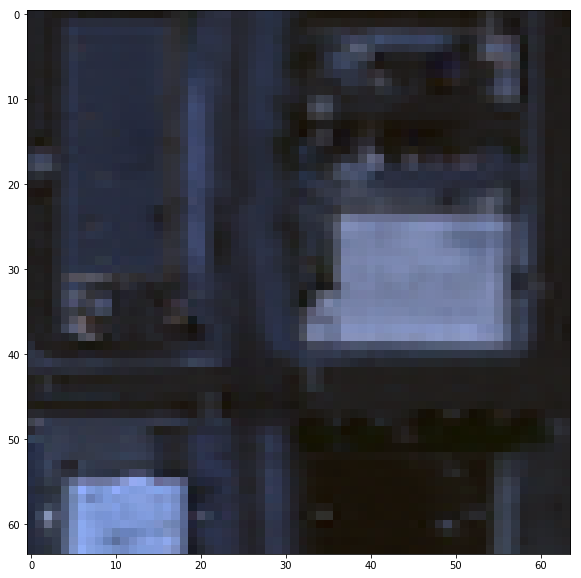

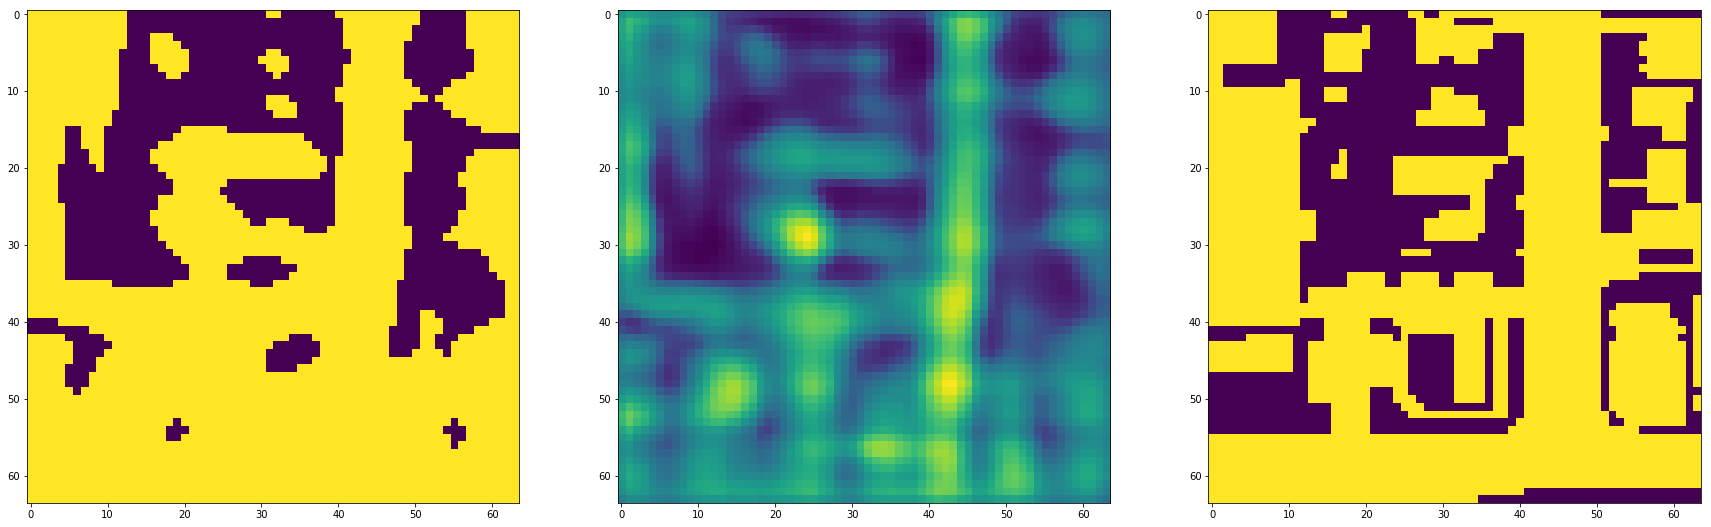

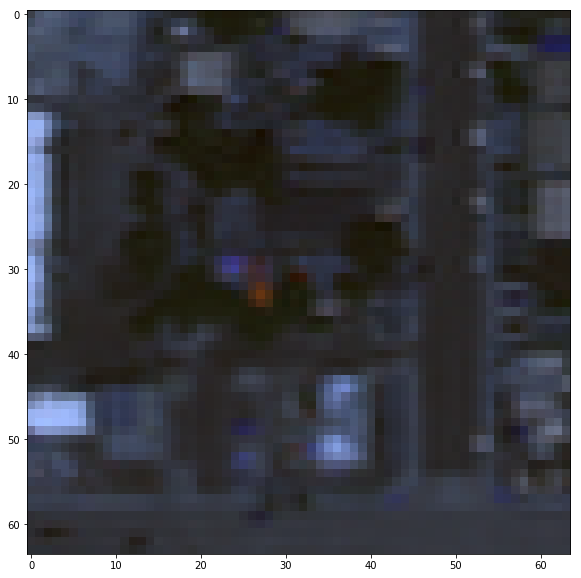

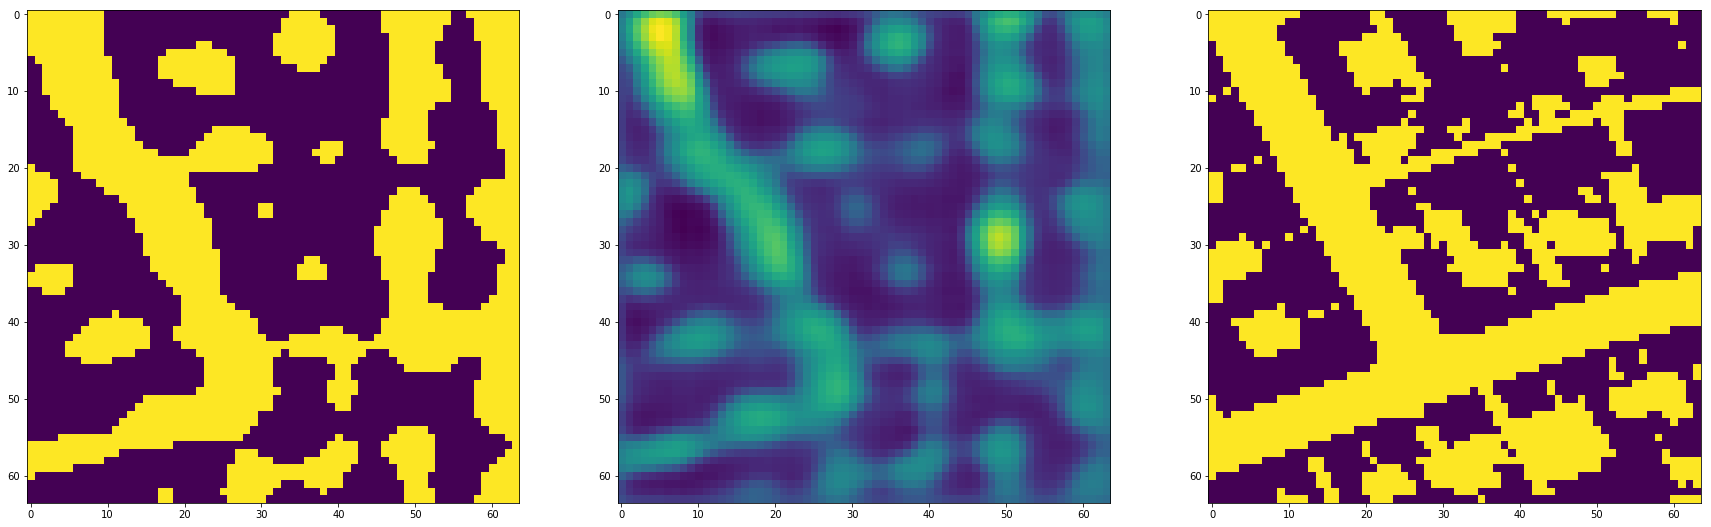

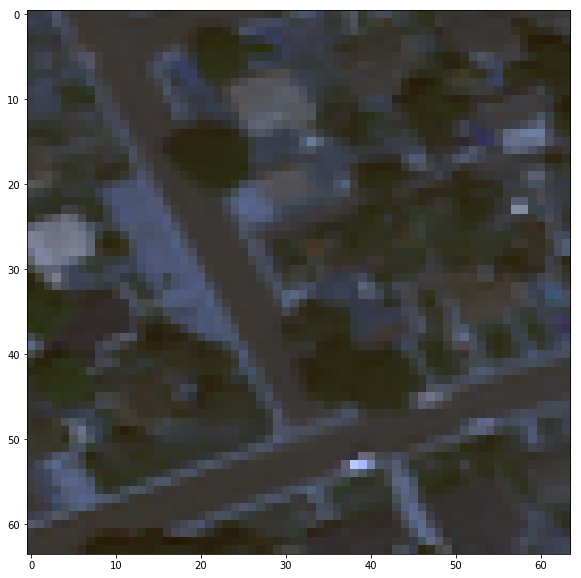

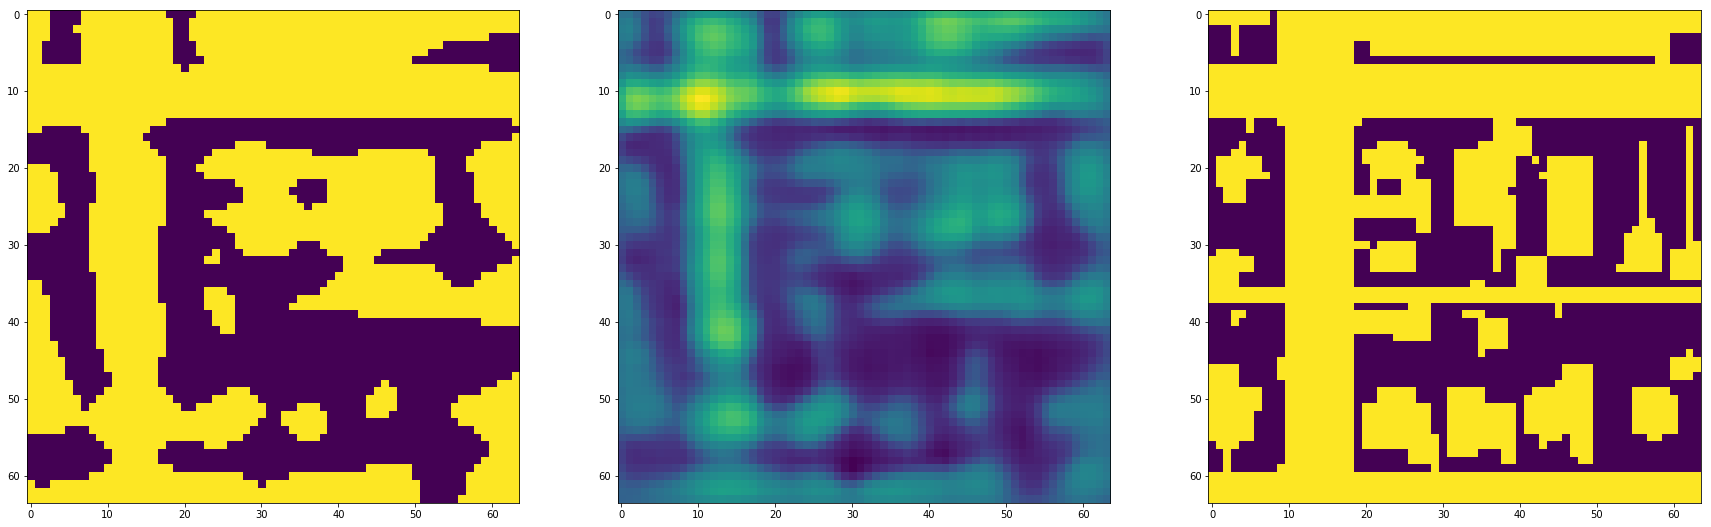

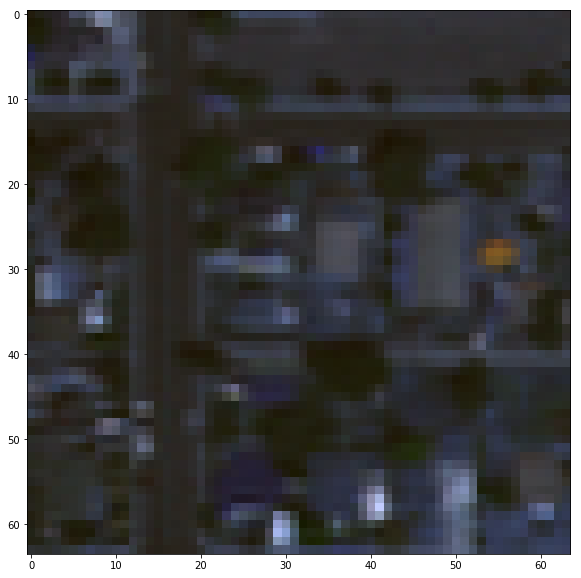

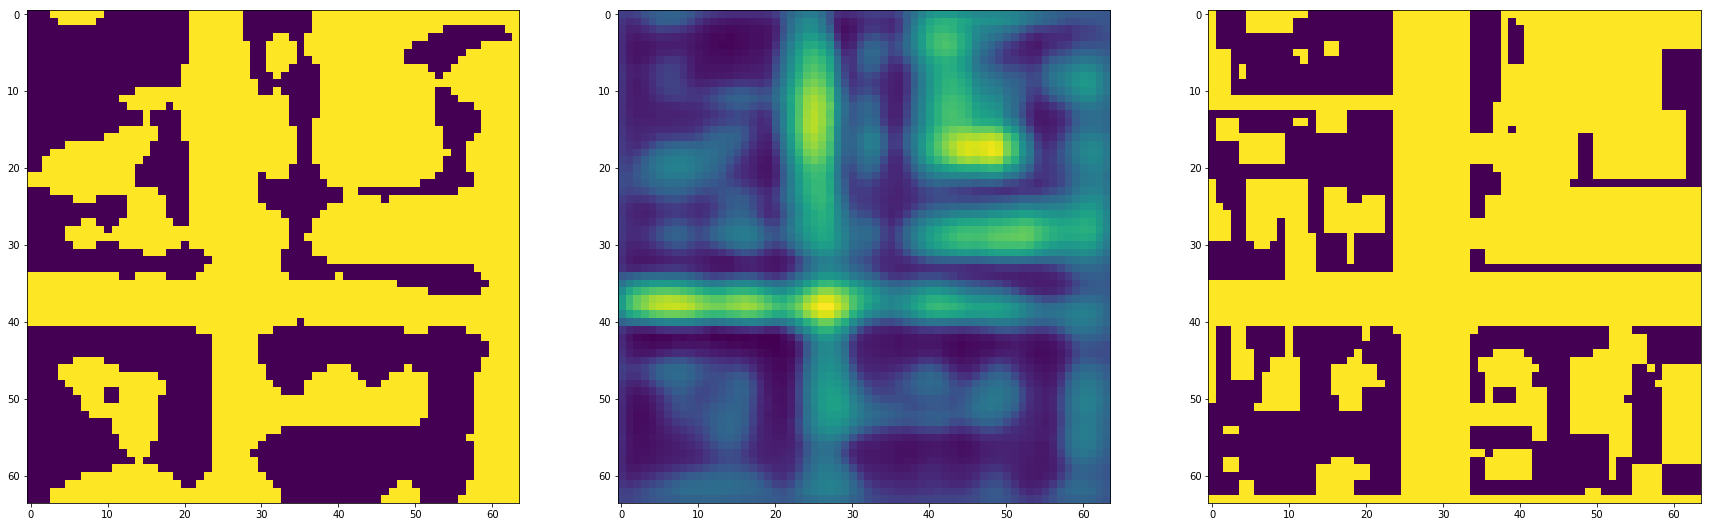

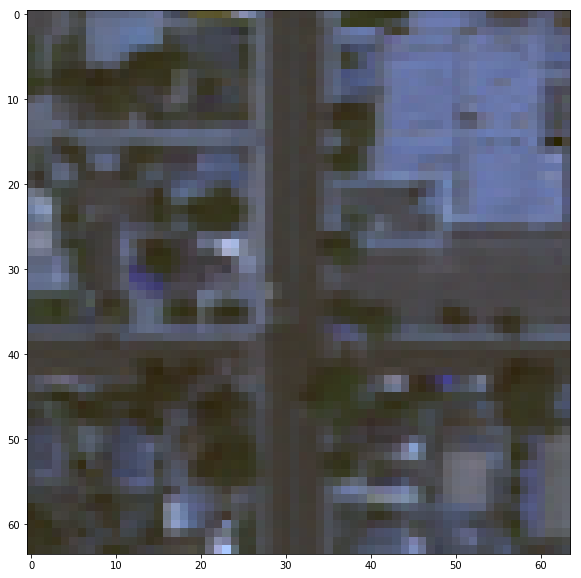

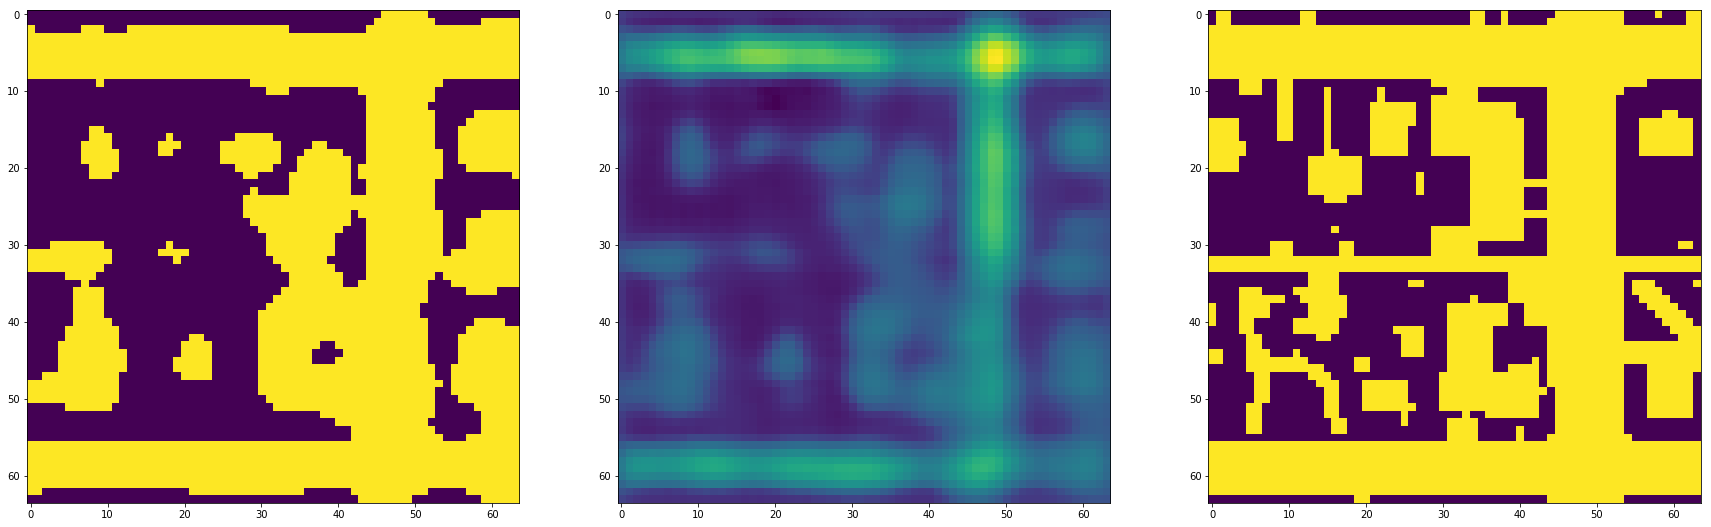

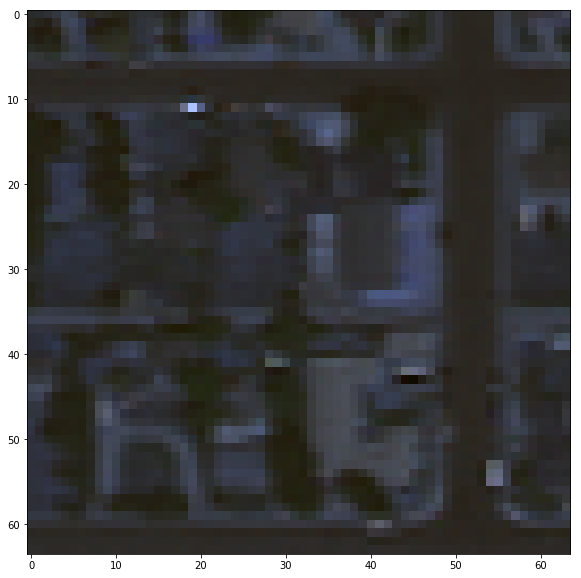

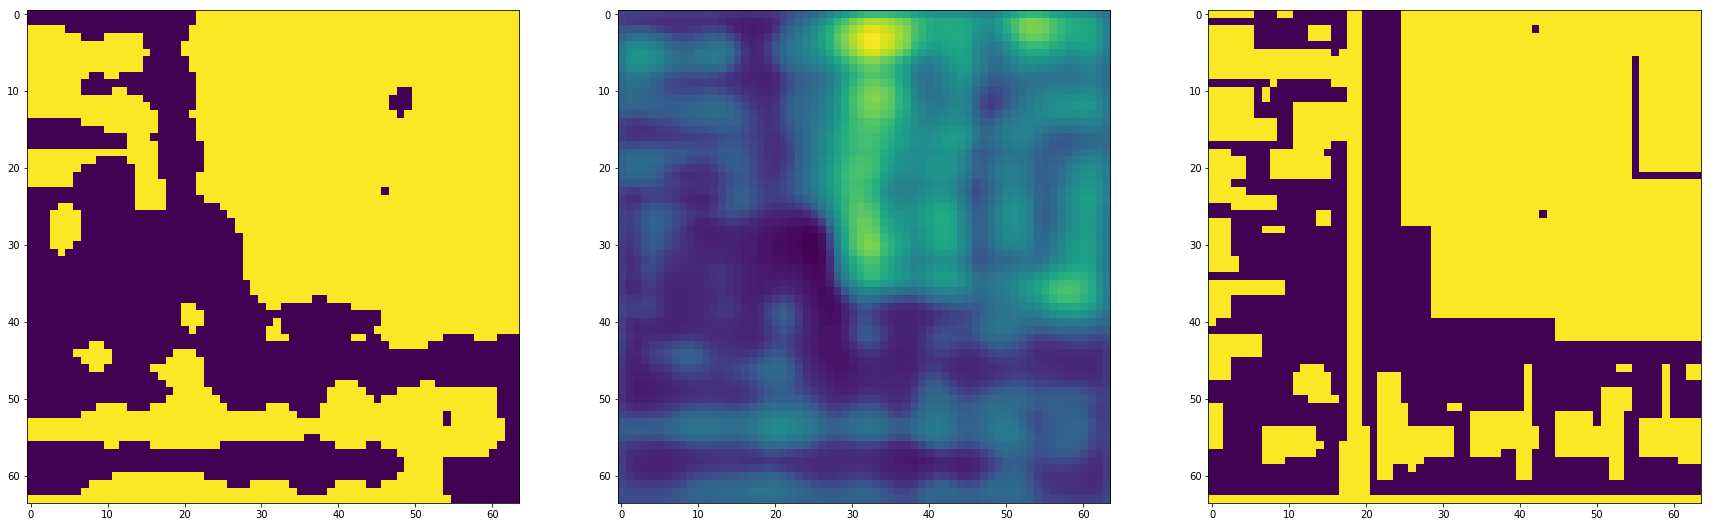

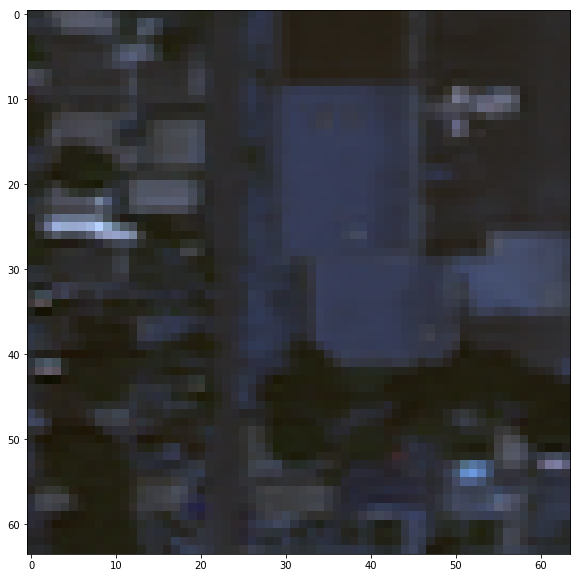

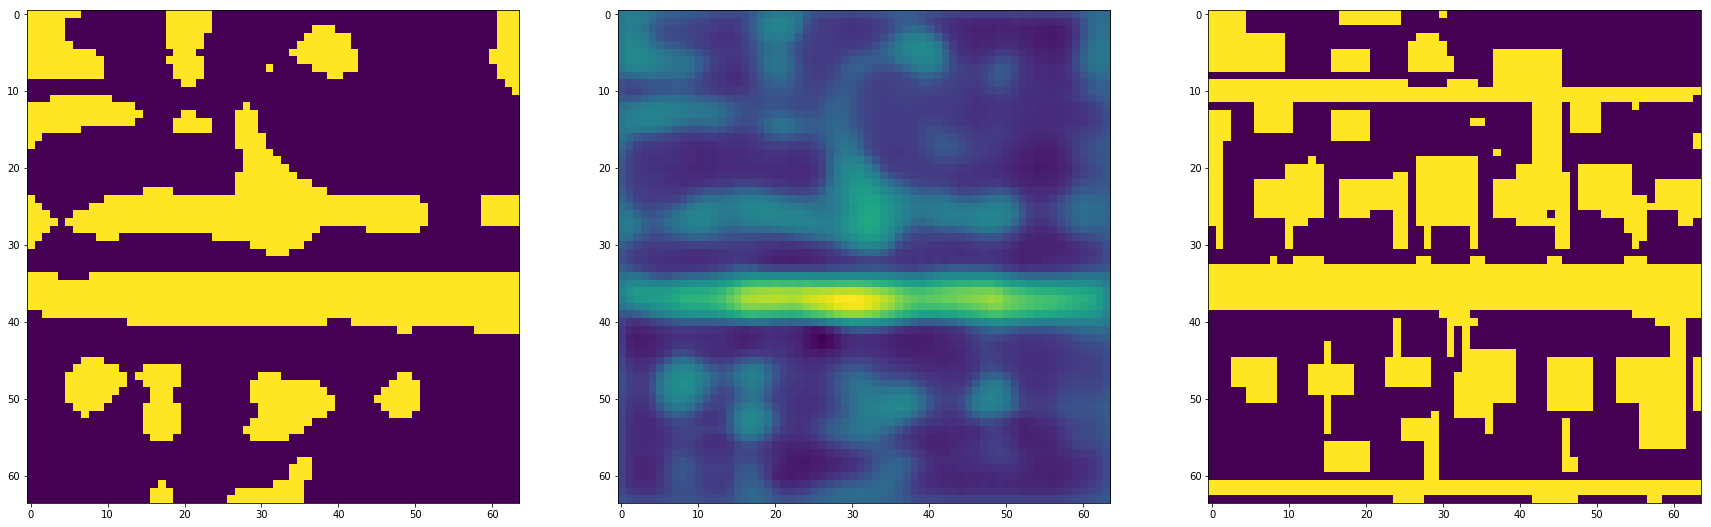

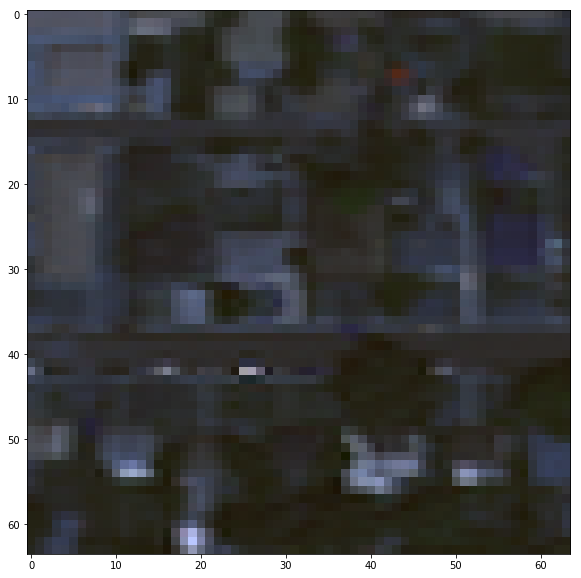

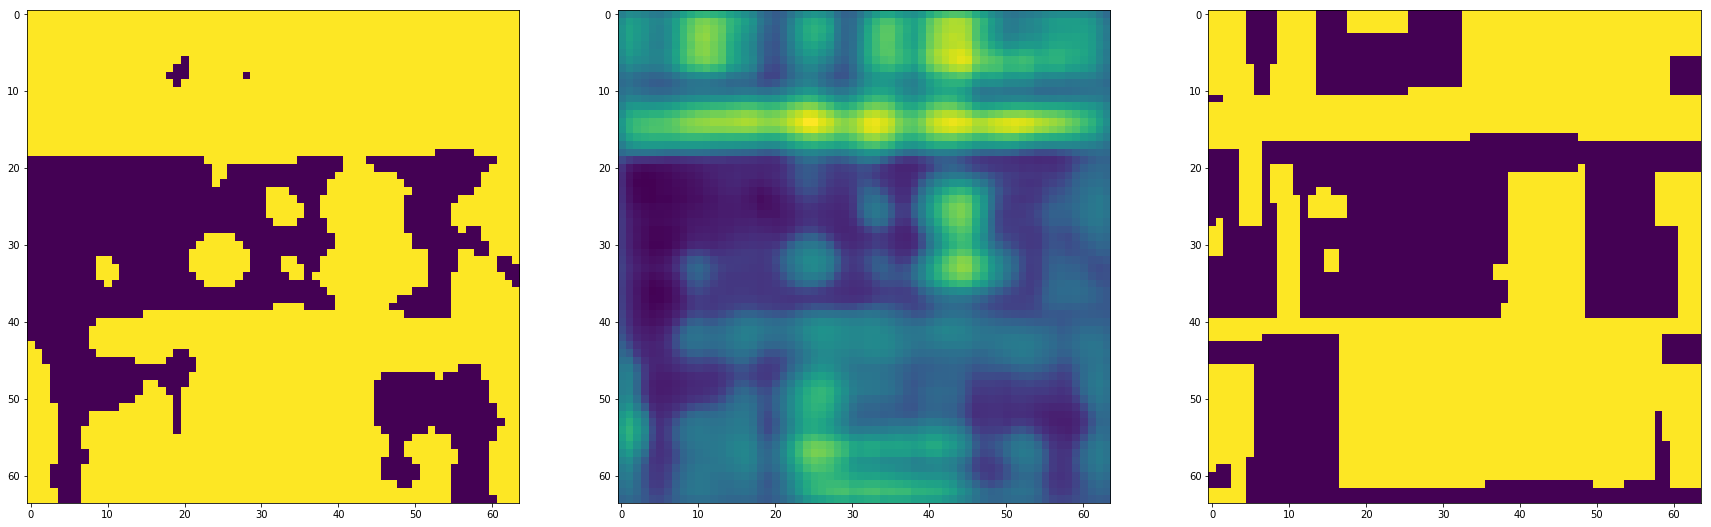

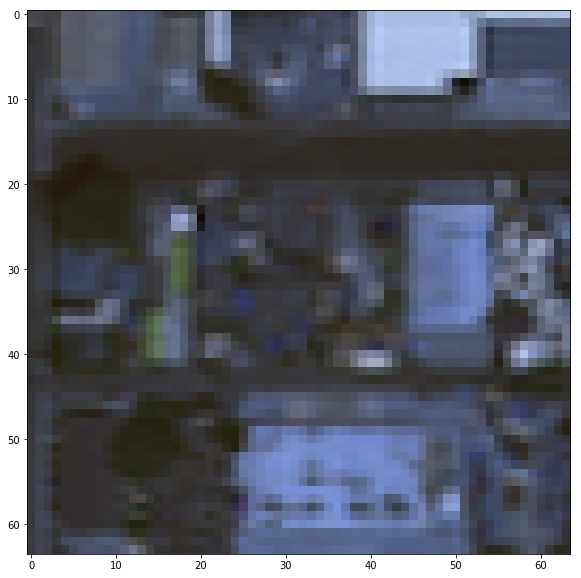

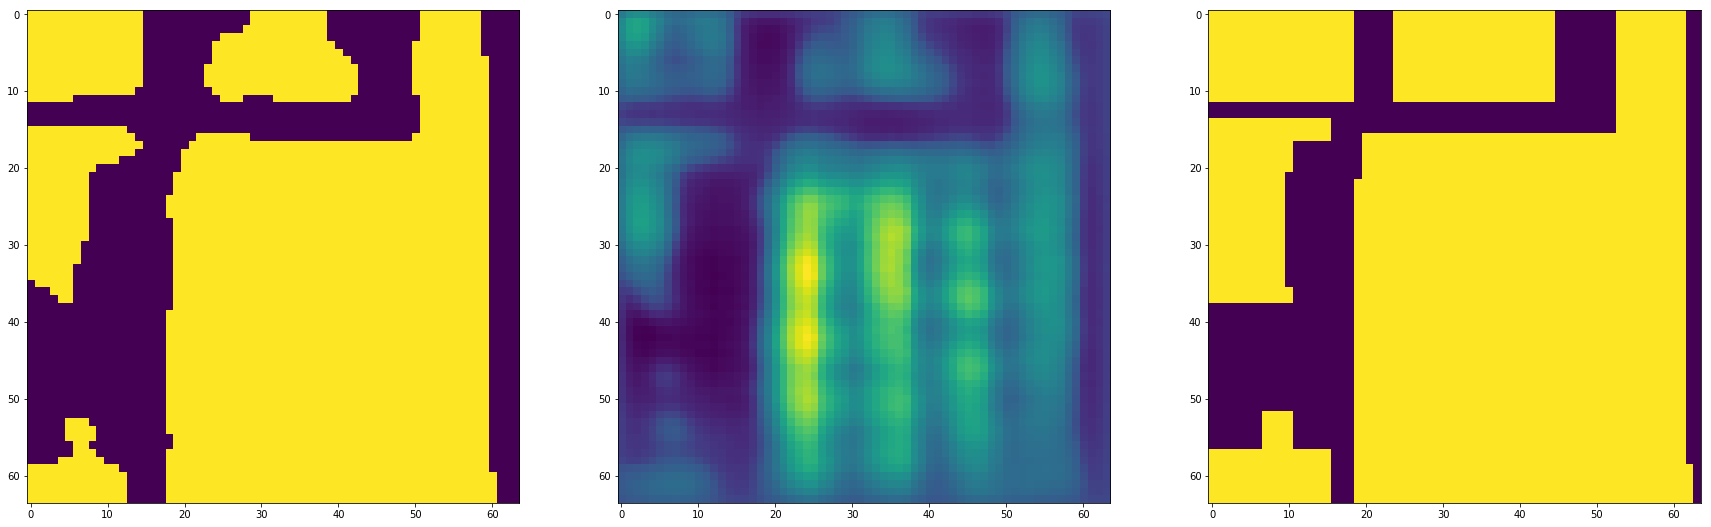

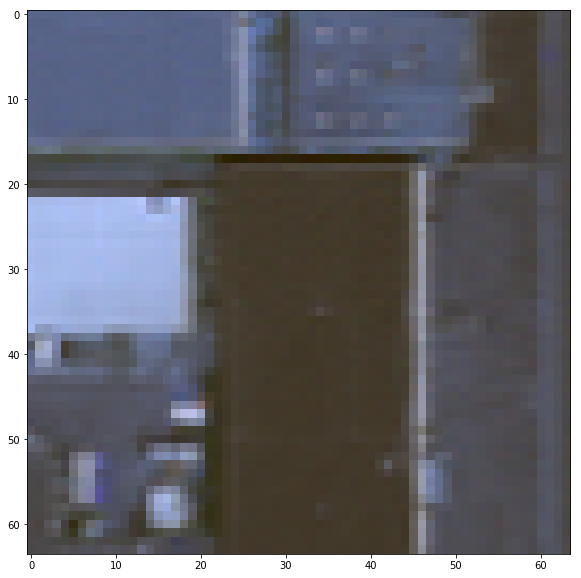

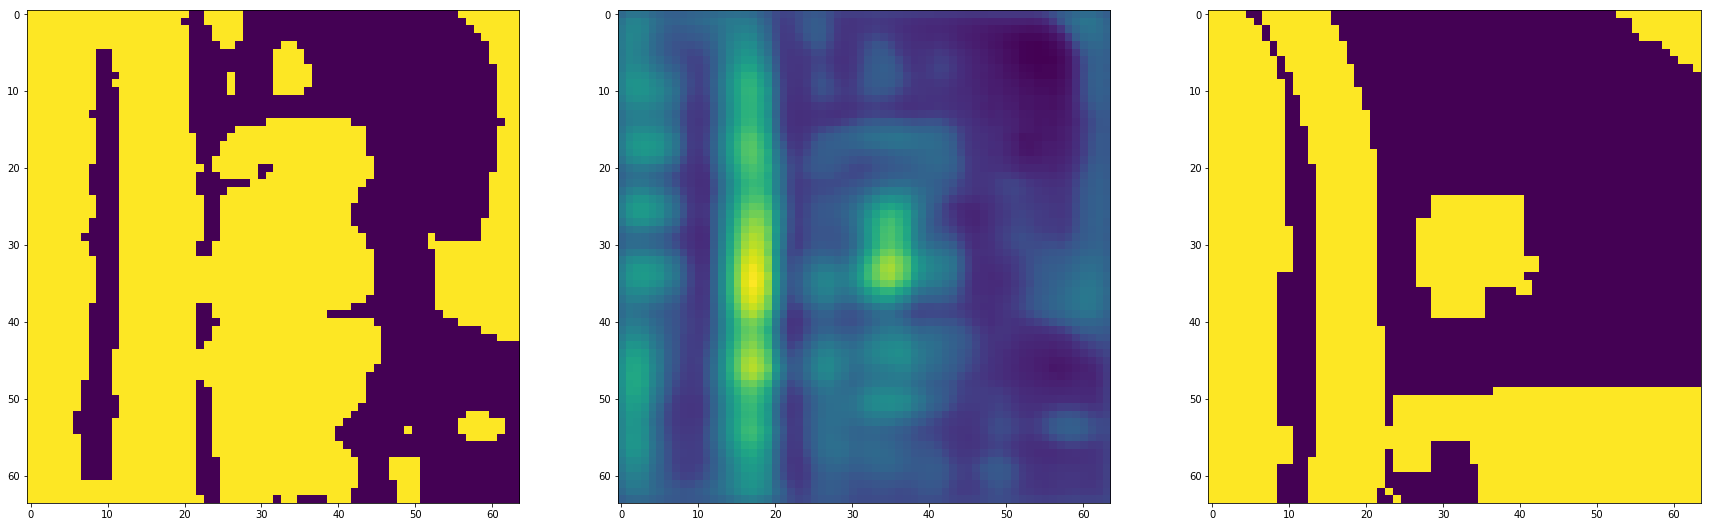

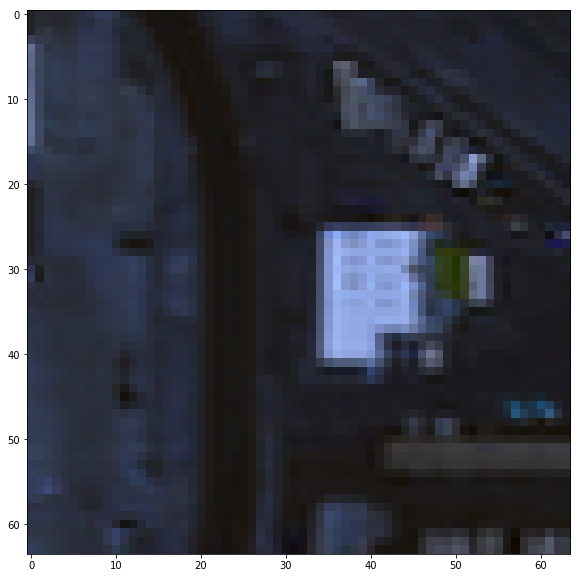

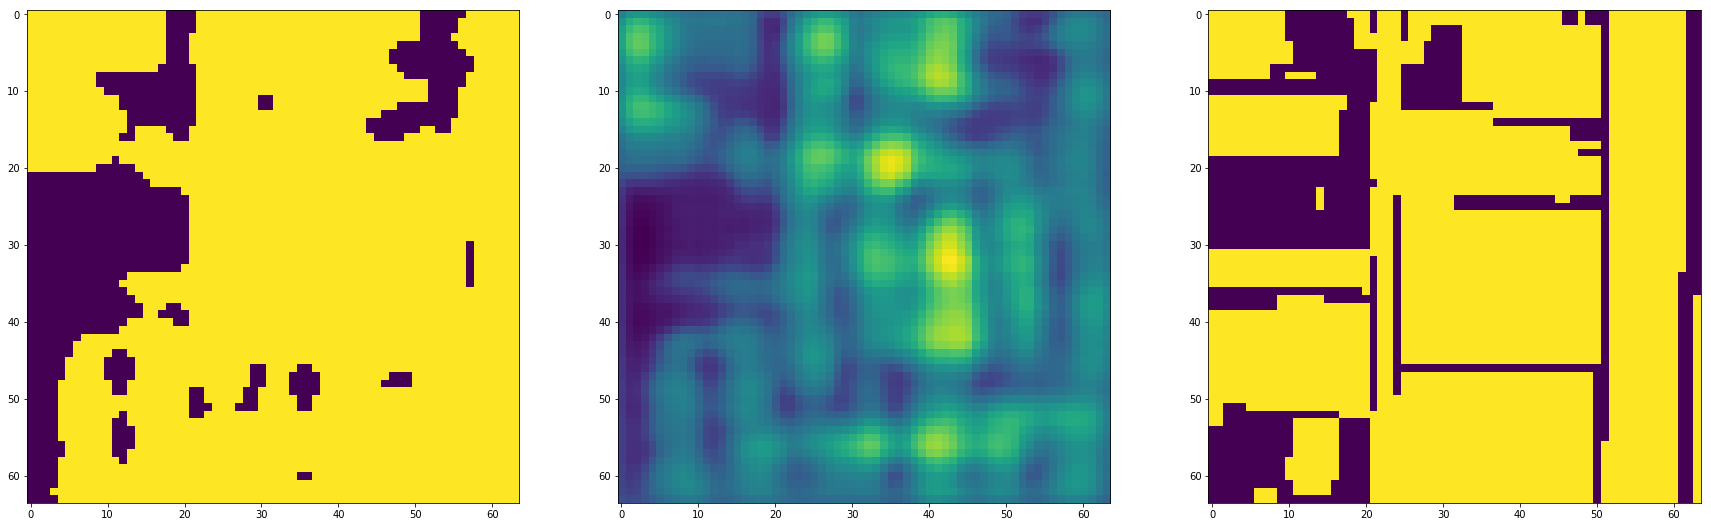

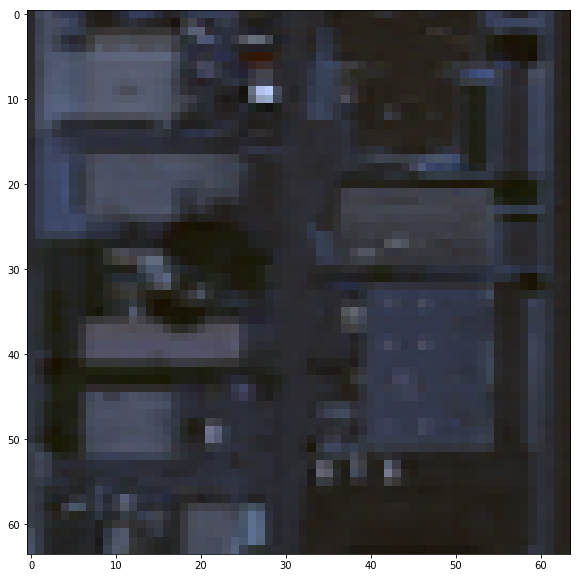

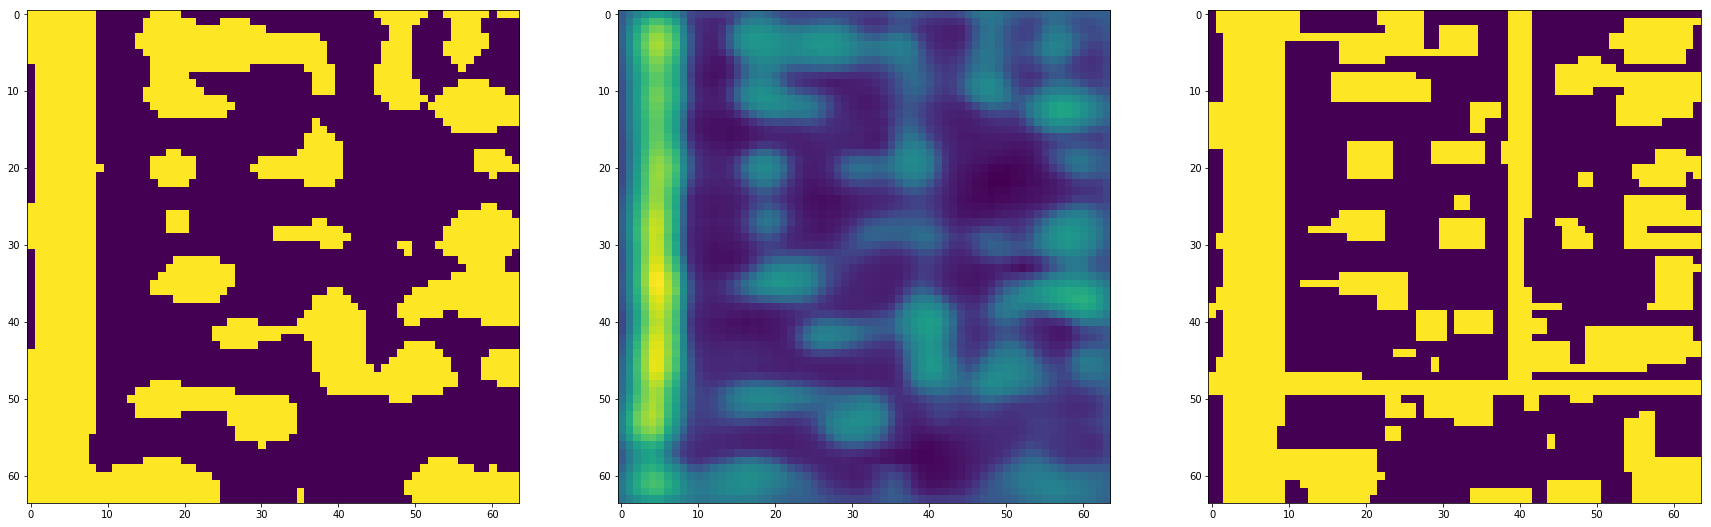

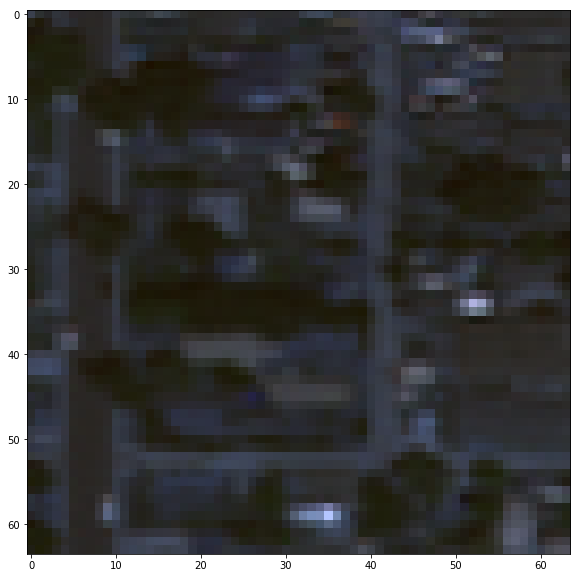

In [23]:
# check one of the test images
test_inds = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700]
for test_ind in test_inds:
    input_img = torch.unsqueeze(variable(dg_dataset_test[test_ind], volatile=True), dim=0) 
    mask = model(input_img)


    mask_im = mask.squeeze().data.cpu().numpy()
    mask_binary = mask_im.copy()

    fig, ax = plt.subplots(1,3, figsize=(30,10))
    thresh = 0
    mask_binary[mask_im<=thresh] = 0
    mask_binary[mask_im>thresh] = 1
    ax[0].imshow(mask_binary)
    # ax[0].colorbar()
    ax[1].imshow(mask_im)
    gt_im = gt_dataset_test[test_ind].numpy().squeeze()
    ax[2].imshow(gt_im)
    # ax[1].colorbar()
    plt.show()

    fig = plt.figure(figsize=(10,10))
    source_im = dg_dataset_test[test_ind].numpy()
    plt.imshow(misc.bytescale(np.rollaxis(source_im, 0, 3)))
    plt.show()



In [24]:
# # temp code to keep running overnight
# timeout = time.time() + 60*60*12   # 5 hours from now
# while True:
#     test = 0
#     time.sleep(1)
#     if test == 5 or time.time() > timeout:
#         break
#     test = test - 1

In [25]:
# # save current state
# save = lambda ep: torch.save({
#         'model': model.state_dict(),
#         'epoch': ep,
#         'step': step,
#     }, str(model_path))

# root = Path('runs/debug')
# model_path = root / 'model_e{}_s{}.pt'.format(epoch, step)
# ep=epoch
# step=i

# save(ep)

In [26]:
# #load model
# if model_path.exists():
#     state = torch.load(str(model_path))
#     epoch = state['epoch']
#     step = state['step']
#     model.load_state_dict(state['model'])
#     print('Restored model, epoch {}, step {:,}'.format(epoch, step))